In [1]:
import numpy as np
import xarray as xr
import dask
import zarr

### Load dataset

In [2]:
# Integrated budget terms
ds_int = xr.open_zarr('/rigel/ocp/users/jt2796/eccov4r3_datasets/anom/budgH_aveZ/intT/0300m')

### Find slope and intercept of linear trend

In [3]:
def linear_fit(y,t):
    y = y.reshape(-1)
    return np.polyfit(t,y,1).reshape(1,1,1,-1)

In [4]:
t = ds_int.time.astype(int)/1e9/3600/24/365.25

In [5]:
ds_slope = xr.Dataset(data_vars={})
ds_itcpt = xr.Dataset(data_vars={})

for varname in ds_int.data_vars:
    y = ds_int[varname].transpose('face','j','i','time').chunk(chunks=(1,1,1,-1))
    fit = dask.array.map_blocks(linear_fit, y.data, t, dtype=np.float64, chunks=(1,1,1,2))
    ds_slope[varname] = xr.DataArray(fit[:,:,:,0],coords=[ds_int.face,ds_int.j,ds_int.i],dims=['face','j','i'])
    ds_itcpt[varname] = xr.DataArray(fit[:,:,:,1],coords=[ds_int.face,ds_int.j,ds_int.i],dims=['face','j','i'])

### Create dataset of linear trend

In [6]:
# Linear trend dataset
ds_trn = ds_itcpt + ds_slope*t

### Get detrended dataset by substracting linear trend

In [7]:
# Detrended dataset
ds_dtr = ds_int - ds_trn

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
f = 2
j = 40
i = 10

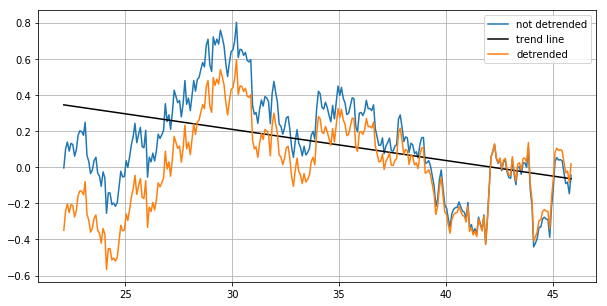

In [15]:
fig = plt.figure(figsize=(10,5))

plt.plot(t,ds_int.frc[:,f,j,i].values, label = 'not detrended')
plt.plot(t,ds_trn.frc[f,j,i].values, color = 'k', label = 'trend line')
plt.plot(t,ds_dtr.frc[:,f,j,i].values, label = 'detrended')
plt.legend()
plt.grid()

plt.show()

### Rechunking

In [16]:
ds_dtr

<xarray.Dataset>
Dimensions:           (face: 13, i: 90, j: 90, time: 286)
Coordinates:
  * face              (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i                 (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * j                 (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * time              (time) datetime64[ns] 1992-02-13 1992-03-15 1992-04-14 ...
Data variables:
    frc               (time, face, j, i) float64 dask.array<shape=(286, 13, 90, 90), chunksize=(286, 1, 1, 1)>
    hadv_Uanom_Tanom  (time, face, j, i) float64 dask.array<shape=(286, 13, 90, 90), chunksize=(286, 1, 1, 1)>
    hadv_Uanom_Tclim  (time, face, j, i) float64 dask.array<shape=(286, 13, 90, 90), chunksize=(286, 1, 1, 1)>
    hadv_Uclim_Tanom  (time, face, j, i) float64 dask.array<shape=(286, 13, 90, 90), chunksize=(286, 1, 1, 1)>
    hdif              (time, face, j, i) float64 dask.array<shape=(286, 13, 90, 90), chunksize=(286, 1, 1, 1)>
    res               (time, face, j

In [17]:
for varname in ds_dtr.data_vars:
    ds_dtr[varname] = ds_dtr[varname].chunk(chunks={'time':286,'face':1,'j':90,'i':90})

In [18]:
ds_dtr

<xarray.Dataset>
Dimensions:           (face: 13, i: 90, j: 90, time: 286)
Coordinates:
  * face              (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i                 (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * j                 (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * time              (time) datetime64[ns] 1992-02-13 1992-03-15 1992-04-14 ...
Data variables:
    frc               (time, face, j, i) float64 dask.array<shape=(286, 13, 90, 90), chunksize=(286, 1, 90, 90)>
    hadv_Uanom_Tanom  (time, face, j, i) float64 dask.array<shape=(286, 13, 90, 90), chunksize=(286, 1, 90, 90)>
    hadv_Uanom_Tclim  (time, face, j, i) float64 dask.array<shape=(286, 13, 90, 90), chunksize=(286, 1, 90, 90)>
    hadv_Uclim_Tanom  (time, face, j, i) float64 dask.array<shape=(286, 13, 90, 90), chunksize=(286, 1, 90, 90)>
    hdif              (time, face, j, i) float64 dask.array<shape=(286, 13, 90, 90), chunksize=(286, 1, 90, 90)>
    res               (tim

### Save to zarr

In [19]:
compressor = zarr.Blosc(cname='zlib')
opts = {}
for varname in ds_dtr.data_vars:
    opts[varname] = {'compressor': compressor, 'chunks': (286, 1, 90, 90)}

#### Save to file

In [20]:
from dask.diagnostics import ProgressBar

In [ ]:
with ProgressBar():
    ds_dtr.to_zarr('/rigel/ocp/users/jt2796/eccov4r3_datasets/anom/budgH_aveZ/intT/dtr/0300m', encoding=opts)